In [82]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import snntorch as snn

# Define parameters
num_inputs = 28 * 28
num_outputs = 10
beta = 0.95
num_steps = 2
batch_size = 128
learning_rate = 5e-4
num_epochs = 3
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
])

train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(num_inputs, num_outputs)
        self.lif = snn.Leaky(beta=beta)

    def forward(self, x):
        batch_size = x.size(0)
        mem = torch.zeros(batch_size, num_outputs).to(device)
        spk_rec = []
        for step in range(num_steps):
            cur = self.fc(x)
            spk, mem = self.lif(cur, mem)
            spk_rec.append(spk)
        return torch.stack(spk_rec, dim=0)

net = Net().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))

# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = net(images)
        loss = loss_fn(outputs.sum(dim=0), labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print('Finished Training')
correct = 0
total = 0

net.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)

        _, predicted = torch.max(outputs.sum(dim=0).data, 1)

        total += labels.size(0)

        correct += (predicted == labels).sum()

accuracy = 100 * correct / total

print(f'Accuracy of the network on the test images: {accuracy:.2f}%')


Epoch [1/3], Step [100/469], Loss: 1.1486
Epoch [1/3], Step [200/469], Loss: 1.0939
Epoch [1/3], Step [300/469], Loss: 1.0596
Epoch [1/3], Step [400/469], Loss: 1.0447
Epoch [2/3], Step [100/469], Loss: 1.0555
Epoch [2/3], Step [200/469], Loss: 1.0058
Epoch [2/3], Step [300/469], Loss: 1.0182
Epoch [2/3], Step [400/469], Loss: 1.0235
Epoch [3/3], Step [100/469], Loss: 1.0029
Epoch [3/3], Step [200/469], Loss: 0.9617
Epoch [3/3], Step [300/469], Loss: 0.9727
Epoch [3/3], Step [400/469], Loss: 0.9692
Finished Training
Accuracy of the network on the test images: 88.62%


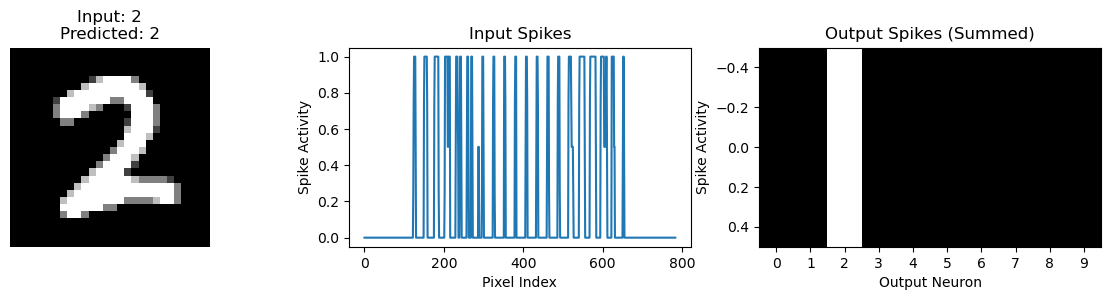

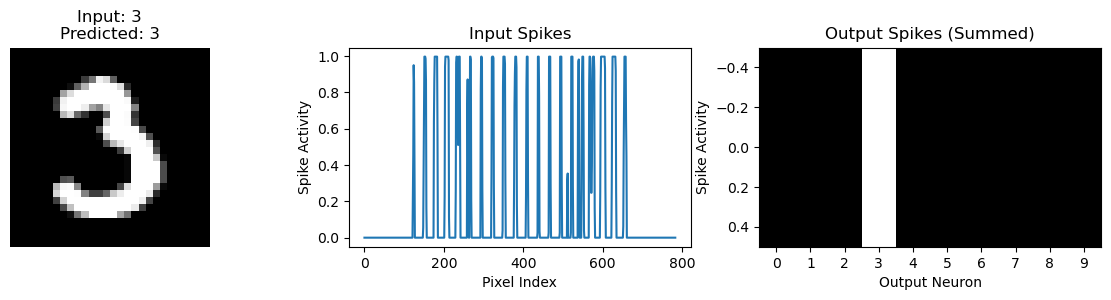

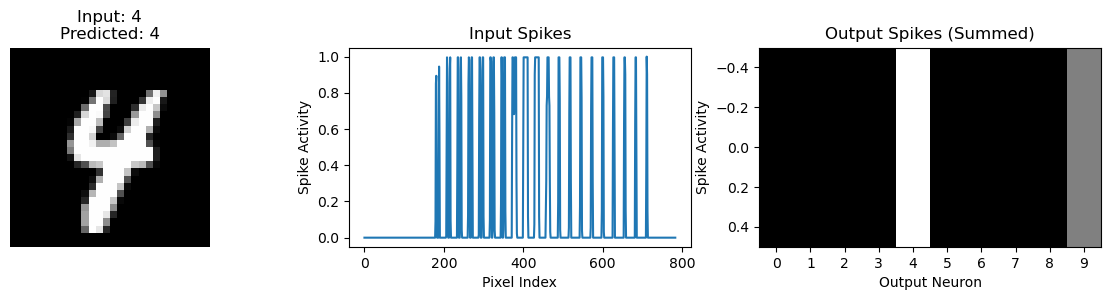

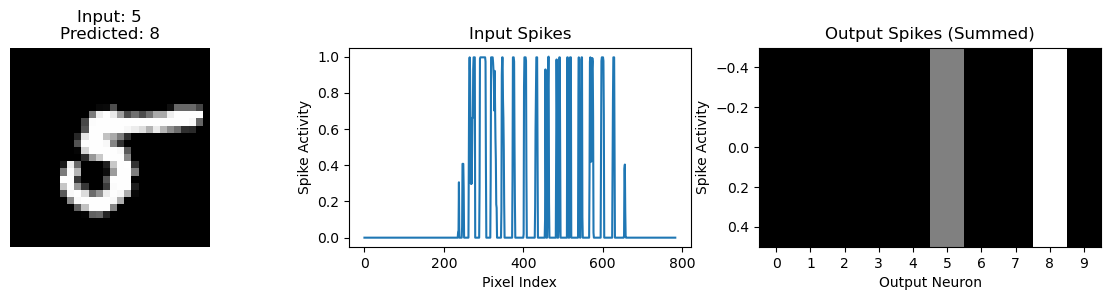

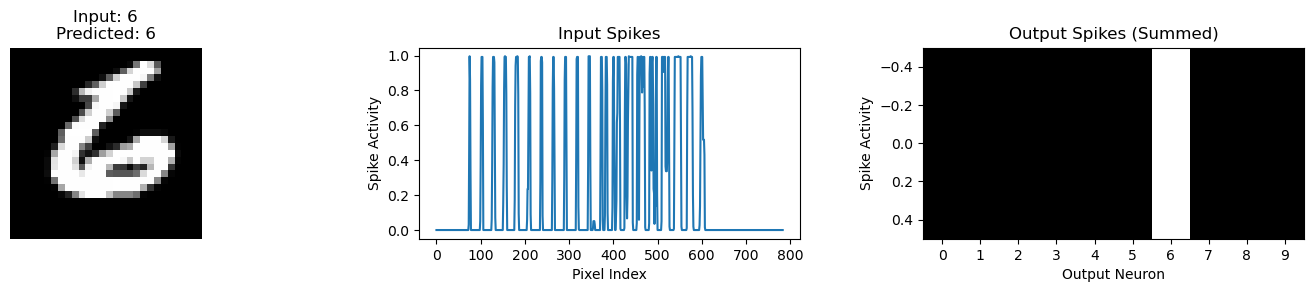

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

net.eval()

num_images = 5
num_rows = 5
num_cols = 3

start_index = len(test_dataset) - num_images

for i in range(start_index, len(test_dataset)):
    image, label = test_dataset[i]
    image = image.to(device)

    outputs = net(image.unsqueeze(0))

    _, predicted = torch.max(outputs.sum(dim=0).data, 1)
    predicted = predicted.item()
    input_spikes = image.squeeze().cpu().detach().numpy()

    output_spikes = outputs.squeeze().cpu().detach().numpy()

    summed_output_spikes = np.sum(output_spikes, axis=0)

    plt.figure(figsize=(15, 15))
    plt.subplot(num_rows, num_cols, 1)
    plt.imshow(input_spikes.reshape(28, 28), cmap='gray')
    plt.title(f"Input: {label}\nPredicted: {predicted}")
    plt.axis('off')

    plt.subplot(num_rows, num_cols, 2)
    plt.plot(input_spikes)
    plt.title('Input Spikes')
    plt.xlabel('Pixel Index')
    plt.ylabel('Spike Activity')

    plt.subplot(num_rows, num_cols, 3)
    plt.imshow(summed_output_spikes.reshape(1, -1), cmap='gray', aspect='auto')
    plt.title('Output Spikes (Summed)')
    plt.xlabel('Output Neuron')
    plt.ylabel('Spike Activity')
    plt.xticks(np.arange(len(summed_output_spikes)))

plt.tight_layout(pad=4.0)
plt.show()


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import snntorch as snn
import cv2

# Define parameters
num_inputs = 14 * 14
num_outputs = 10
beta = 0.95
num_steps = 200
batch_size = 128
learning_rate = 5e-4
num_epochs = 3
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

transform = transforms.Compose([
    transforms.Resize((14, 14)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
])

train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(num_inputs, num_outputs)
        self.lif = snn.Leaky(beta=beta)

    def forward(self, x):
        batch_size = x.size(0)
        mem = torch.zeros(batch_size, num_outputs).to(device)  # Fix: Adjust the size of the membrane potential tensor
        spk_rec = []
        for step in range(num_steps):
            cur = self.fc(x)
            spk, mem = self.lif(cur, mem)
            spk_rec.append(spk)
        return torch.stack(spk_rec, dim=0)

net = Net().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))

# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = net(images)
        loss = loss_fn(outputs.sum(dim=0), labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print('Finished Training')
correct = 0
total = 0

net.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)

        _, predicted = torch.max(outputs.sum(dim=0).data, 1)

        total += labels.size(0)

        correct += (predicted == labels).sum()

accuracy = 100 * correct / total

print(f'Accuracy of the network on the test images: {accuracy:.2f}%')


Epoch [1/3], Step [100/469], Loss: 1.8303
Epoch [1/3], Step [200/469], Loss: 1.7835
Epoch [1/3], Step [300/469], Loss: 1.0589
Epoch [1/3], Step [400/469], Loss: 1.3644
Epoch [2/3], Step [100/469], Loss: 1.1350
Epoch [2/3], Step [200/469], Loss: 1.4676
Epoch [2/3], Step [300/469], Loss: 1.2851
Epoch [2/3], Step [400/469], Loss: 1.8978
Epoch [3/3], Step [100/469], Loss: 1.2732
Epoch [3/3], Step [200/469], Loss: 0.8197
Epoch [3/3], Step [300/469], Loss: 0.7288
Epoch [3/3], Step [400/469], Loss: 0.8476
Finished Training
Accuracy of the network on the test images: 89.93%


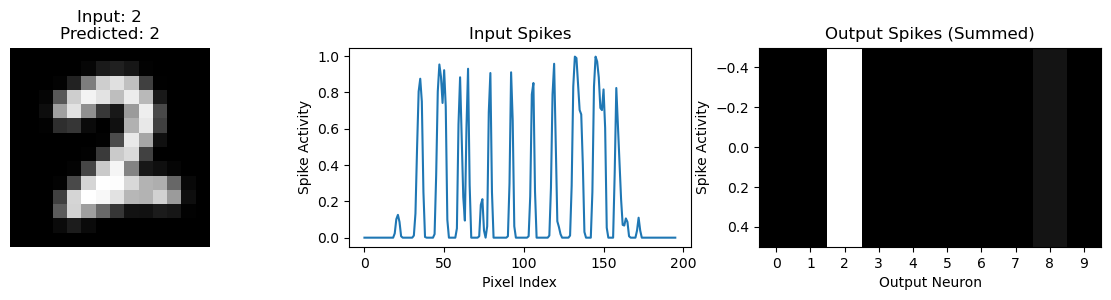

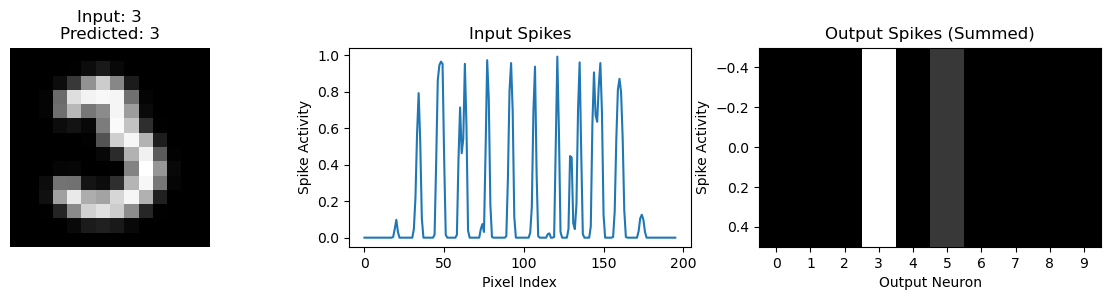

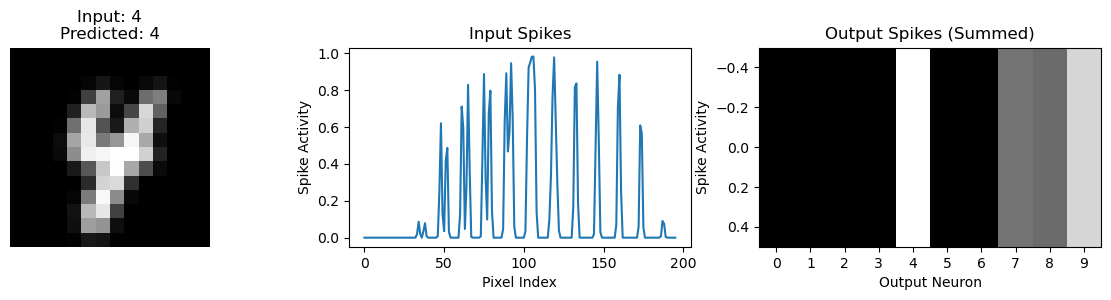

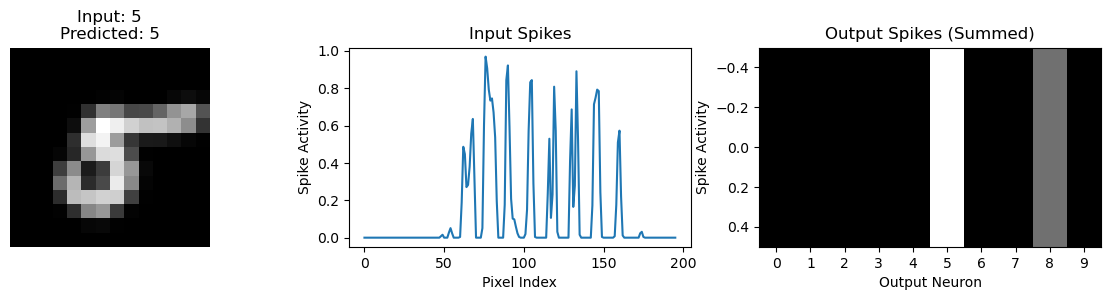

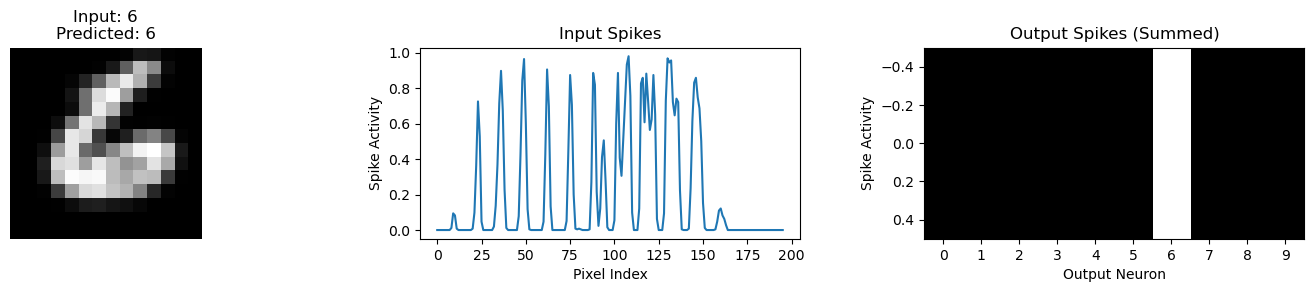

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

net.eval()

num_images = 5
num_rows = 5
num_cols = 3

start_index = len(test_dataset) - num_images

for i in range(start_index, len(test_dataset)):
    image, label = test_dataset[i]
    image = image.to(device)

    outputs = net(image.unsqueeze(0))

    _, predicted = torch.max(outputs.sum(dim=0).data, 1)
    predicted = predicted.item()
    input_spikes = image.squeeze().cpu().detach().numpy()

    output_spikes = outputs.squeeze().cpu().detach().numpy()

    summed_output_spikes = np.sum(output_spikes, axis=0)

    plt.figure(figsize=(15, 15))
    plt.subplot(num_rows, num_cols, 1)
    plt.imshow(input_spikes.reshape(14, 14), cmap='gray')
    plt.title(f"Input: {label}\nPredicted: {predicted}")
    plt.axis('off')

    plt.subplot(num_rows, num_cols, 2)
    plt.plot(input_spikes)
    plt.title('Input Spikes')
    plt.xlabel('Pixel Index')
    plt.ylabel('Spike Activity')

    plt.subplot(num_rows, num_cols, 3)
    plt.imshow(summed_output_spikes.reshape(1, -1), cmap='gray', aspect='auto')
    plt.title('Output Spikes (Summed)')
    plt.xlabel('Output Neuron')
    plt.ylabel('Spike Activity')
    plt.xticks(np.arange(len(summed_output_spikes)))

plt.tight_layout(pad=4.0)
plt.show()


In [58]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

num_inputs = 10 * 10
beta = 0.95
num_steps = 4
batch_size = 128
learning_rate = 5e-4
num_epochs = 1
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

transform = transforms.Compose([
    transforms.Resize((10, 10)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(num_inputs, 2)
        self.lif = snn.Leaky(beta=beta)

    def forward(self, x):
        batch_size = x.size(0)
        mem = torch.zeros(batch_size, 2).to(device)
        spk_rec = []
        for step in range(num_steps):
            cur = self.fc(x)
            spk, mem = self.lif(cur, mem)
            spk_rec.append(spk)
        return torch.stack(spk_rec, dim=0)

# Define the necessary components
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

loss_fn = nn.CrossEntropyLoss()

for i in range(10):
    for j in range(i+1, 10):
        net = Net().to(device)
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))

        for epoch in range(num_epochs):
            for k, (images, labels) in enumerate(train_loader):
                idx = (labels == i) | (labels == j)
                images = images[idx].to(device)
                labels = labels[idx].to(device)

                labels = (labels == j).long()

                outputs = net(images)
                loss = loss_fn(outputs.sum(dim=0), labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if (k+1) % 100 == 0:
                    print(f'Digit pair: [{i},{j}], Epoch [{epoch+1}/{num_epochs}], Step [{k+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        torch.save(net.state_dict(), f"weights{i}{j}.pth")

        correct = 0
        total = 0
        net.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                idx = (labels == i) | (labels == j)
                images = images[idx].to(device)
                labels = labels[idx].to(device)

                labels = (labels == j).long()

                outputs = net(images)
                _, predicted = torch.max(outputs.sum(dim=0).data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Accuracy of the network on the test images for digits {i} and {j}: {accuracy:.2f}%')


Digit pair: [0,1], Epoch [1/1], Step [100/469], Loss: 0.2218
Digit pair: [0,1], Epoch [1/1], Step [200/469], Loss: 0.1001
Digit pair: [0,1], Epoch [1/1], Step [300/469], Loss: 0.1108
Digit pair: [0,1], Epoch [1/1], Step [400/469], Loss: 0.0515
Accuracy of the network on the test images for digits 0 and 1: 99.72%
Digit pair: [0,2], Epoch [1/1], Step [100/469], Loss: 0.2707
Digit pair: [0,2], Epoch [1/1], Step [200/469], Loss: 0.1833
Digit pair: [0,2], Epoch [1/1], Step [300/469], Loss: 0.0617
Digit pair: [0,2], Epoch [1/1], Step [400/469], Loss: 0.1585
Accuracy of the network on the test images for digits 0 and 2: 97.32%
Digit pair: [0,3], Epoch [1/1], Step [100/469], Loss: 0.2741
Digit pair: [0,3], Epoch [1/1], Step [200/469], Loss: 0.2100
Digit pair: [0,3], Epoch [1/1], Step [300/469], Loss: 0.1445
Digit pair: [0,3], Epoch [1/1], Step [400/469], Loss: 0.1071
Accuracy of the network on the test images for digits 0 and 3: 98.99%
Digit pair: [0,4], Epoch [1/1], Step [100/469], Loss: 0.50

ONE-VS-ONE

In [59]:
models = []
for i in range(10):
    for j in range(i+1, 10):
        model = Net().to(device)
        model.load_state_dict(torch.load(f"weights{i}{j}.pth"))
        model.eval()
        models.append((model, i, j))

confusion_matrix = torch.zeros(10, 10)

test_data = torch.utils.data.Subset(test_dataset, range(-2000, 0))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# Test
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        votes = torch.zeros(images.shape[0], 10).to(device)

        for model, i, j in models:
            outputs = model(images)
            outputs_sum = outputs.sum(dim=0)
            _, predicted = torch.max(outputs_sum, dim=1)

            for idx, pred in enumerate(predicted):
                if pred == 0:
                    votes[idx, i] += 1
                else:  # pred == 1
                    votes[idx, j] += 1

        _, predicted = torch.max(votes, 1)

        for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

correct = torch.trace(confusion_matrix)
total = torch.sum(confusion_matrix)
accuracy = 100 * correct / total

print(f'Accuracy of the network on the test images: {accuracy:.2f}%')



Accuracy of the network on the test images: 89.95%


In [65]:
torch.load(f"weights12.pth")

OrderedDict([('fc.weight',
              tensor([[ 6.9101e-02, -5.2677e-02, -1.7678e-02, -3.2396e-02, -1.2036e-01,
                       -7.6029e-02, -1.5892e-01, -9.5660e-03, -6.1513e-02, -1.6871e-02,
                       -1.8803e-02, -4.4808e-02, -9.8146e-02, -1.8182e-01, -8.5733e-02,
                        1.9958e-02,  6.5241e-02,  1.0537e-01,  6.8187e-02, -2.5340e-02,
                        8.9009e-02, -7.0727e-02, -1.7712e-01, -2.4105e-01, -9.6635e-05,
                        3.9057e-02,  1.1013e-02,  1.3046e-01, -1.6282e-02,  6.6069e-03,
                        7.1485e-02, -8.2327e-02, -1.3294e-01, -2.0928e-01,  1.1279e-01,
                        1.9433e-01,  7.2637e-02, -1.7895e-02, -9.7862e-02, -3.9644e-02,
                       -3.9021e-02, -1.9293e-02, -1.0735e-01, -1.2234e-01,  2.1158e-01,
                        2.2039e-01, -1.1337e-02, -1.7517e-01, -7.0962e-02, -1.1544e-01,
                       -8.5352e-02, -1.4906e-01, -1.4539e-01, -1.8068e-01,  3.2120e-02,
     